<a href="https://colab.research.google.com/github/tortor04/229352-StatisticalLearning/blob/main/Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#660510741 ธัญพิสิษฐ์ ณ คำ

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [3]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [4]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [7]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [8]:
train_loader

In [9]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


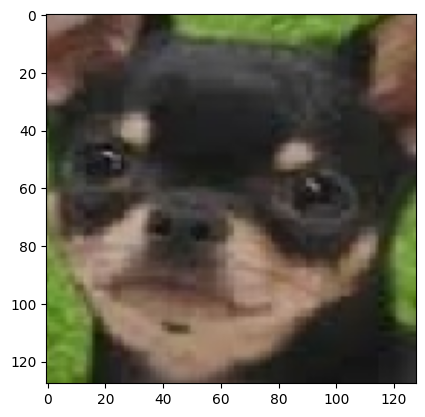

In [10]:
plt.imshow(X[0].numpy().transpose(1, 2, 0))

In [11]:
y

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

#### Visualize the first four images in the batch

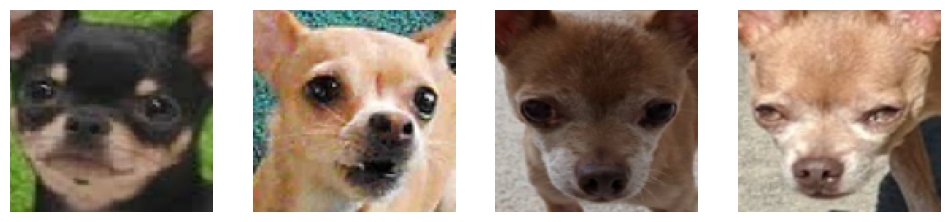

tensor([0, 0, 0, 0])


In [12]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [13]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(3 * 128 * 128, 1) # Corrected input size for the linear layer
    self.activation = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    x = self.activation(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [14]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [15]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [16]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [17]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [18]:
train_batches = iter(train_loader)
X, y = next(train_batches)

In [19]:
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [20]:
y_hat = model(X)

y_hat = y_hat[:, 0]
y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [21]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

In [22]:
train_losses

[0.6931471824645996]

#### Calculate the gradient (Backward pass)

In [23]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()

In [24]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [25]:
for param in model.parameters():
  print(param.grad)

tensor([[-0.0851, -0.0841, -0.0851,  ..., -0.1275, -0.1298, -0.1341]])
tensor([-0.1000])


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [26]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

In [27]:
for param in model.parameters():
  print(param.grad)

None
None


#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [28]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [29]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.9414904713630676]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

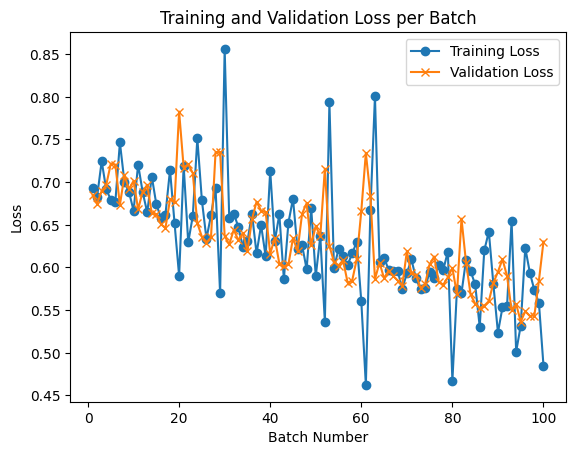

In [30]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

Test Accuracy: 56.67%

Displaying 4 incorrectly classified images:


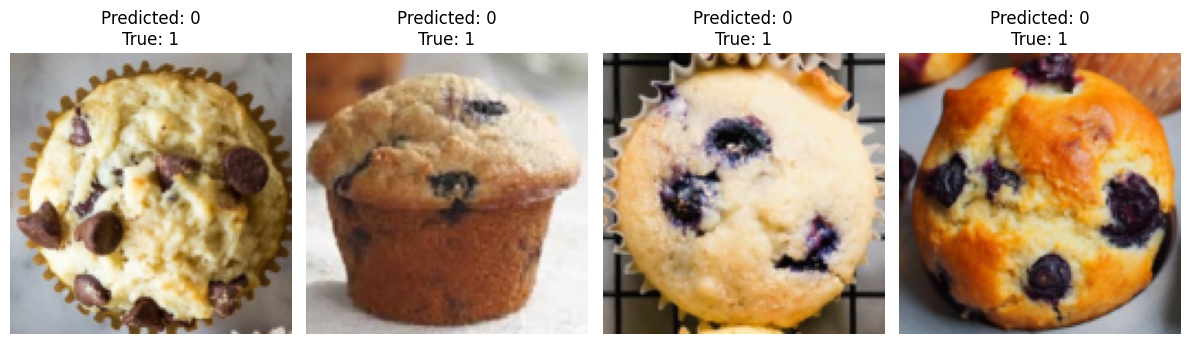

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assume 'model', 'test_loader' are already defined and the model is trained

# Set the model to evaluation mode
model.eval()

# To store misclassified images and their labels
misclassified_images = []
misclassified_predictions = []
misclassified_true_labels = []

correct_predictions = 0
total_predictions = 0

# Use this code to calculate test accuracy
with torch.no_grad():
  # Iterate over the entire test set
  for X_batch, y_batch in test_loader:
    # Make predictions
    y_hat = model(X_batch)
    y_hat = y_hat[:, 0]
    predictions = (y_hat > 0.5).float() # Convert probabilities to 0 or 1

    # --- TODO: compute accuracy ---
    # Compare predictions with true labels
    correct_predictions += (predictions == y_batch).sum().item()
    total_predictions += y_batch.size(0)
    # -----------------------------

    # Find indices of misclassified images
    misclassified_indices = (predictions != y_batch).nonzero(as_tuple=True)[0]

    # Store the misclassified images and labels
    for idx in misclassified_indices:
        if len(misclassified_images) < 4: # Store only 4 for plotting
            misclassified_images.append(X_batch[idx])
            misclassified_predictions.append(predictions[idx].item())
            misclassified_true_labels.append(y_batch[idx].item())


# Calculate the final accuracy
accuracy = (correct_predictions / total_predictions) * 100
print(f"Test Accuracy: {accuracy:.2f}%")


# --- Display four incorrectly classified images ---
if misclassified_images:
    print("\nDisplaying 4 incorrectly classified images:")
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))
    for i, ax in enumerate(axes):
        # Reshape the image tensor for plotting
        image = misclassified_images[i].squeeze().permute(1, 2, 0) # Transpose the tensor
        pred_label = int(misclassified_predictions[i])
        true_label = int(misclassified_true_labels[i])

        ax.imshow(image) # Removed cmap='gray' as it's a color image
        ax.set_title(f"Predicted: {pred_label}\nTrue: {true_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo images were misclassified!")